[View in Colaboratory](https://colab.research.google.com/github/jesandovala/Project-Final-Classification-Images/blob/master/MOVIES_FPROJECT_V7.ipynb)

####Created by Aleksey Sepúlveda Durán & Jose Eduardo Sandoval Alba

In [0]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


# Deep Learning - Project Final - Classification Movies

![Image of Yaktocat](http://usblogs.pwc.com/emerging-technology/wp-content/uploads/2017/07/deep-learning-900x280.png)

### Import Modules

In [0]:

!pip install tqdm
!pip install livelossplot
!pip install -U -q PyDrive
!pip install pprint

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import keras.optimizers as krsopt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tqdm import tqdm
from zipfile import *
from livelossplot import PlotLossesKeras
from pprint import pprint



%matplotlib inline

    100% |████████████████████████████████| 51kB 1.8MB/s 
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py bdist_wheel for livelossplot ... - \ done
  Stored in directory: /content/.cache/pip/wheels/67/8b/e9/3990164e3b2a421145b9d9d76fc8aa889225d495b043faeb73
Successfully built livelossplot
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py bdist_wheel for pprint ... -

 done
  Stored in directory: /content/.cache/pip/wheels/42/d4/c6/16a6495aecc1bda5d5857bd036efd50617789ba9bea4a05124
Successfully built pprint
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### In this part the information is imported from Git Hub

In [0]:
dataTesting = pd.read_csv(os.path.join('https://github.com/jesandovala/Project-Final-Classification-Images/raw/master/dataTesting.csv'), encoding='UTF-8', index_col=0)
dataTraining = pd.read_csv(os.path.join('https://github.com/jesandovala/Project-Final-Classification-Images/raw/master/dataTraining.csv'), encoding='UTF-8', index_col=0)

dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


### Because there is no local access from Colab to the information, it was uploaded and imported from there

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1cFX4osUZTu-SSa8gHh8kRA00L3eQwWnI'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])

### The file is unzipped and the existence of the information is verified

In [0]:
!unzip images_resize_gray.zip> /dev/null

In [0]:
!ls

datalab  images_resize_gray  images_resize_gray.zip


In [0]:
from skimage import io
image = io.imread(os.path.join( 'images_resize_gray', str(dataTraining.index[110]) + '_resize_gray.jpeg'))

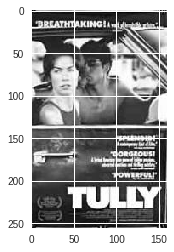

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

### A set of information is created with the training taking into account the movie numbers that are inside the train file. This same process is done for test.

In [0]:

images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join('images_resize_gray', str(i) + '_resize_gray.jpeg')))



100%|██████████| 7895/7895 [00:05<00:00, 1558.76it/s]


In [0]:
images_training = np.stack(images_training)

images_training.shape, dataTraining.shape[0]

((7895, 256, 160), 7895)

In [0]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join( 'images_resize_gray', str(i) + '_resize_gray.jpeg')))

images_testing = np.stack(images_testing)

images_testing.shape, dataTesting.shape[0]

100%|██████████| 3383/3383 [00:02<00:00, 1664.42it/s]


((3383, 256, 160), 3383)

In [0]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training, y_genres, test_size=0.3, random_state=110)

In [0]:
X_test.shape

(2369, 256, 160)

In [0]:
y_test_genres.shape

(2369, 24)

# CNN

![Image of Yaktocat](http://www.ifp.uni-stuttgart.de/lehre/master_thesis/laupheimer/fig1.png)

###  Initially a CNN network was made with 6 layers within them Relu activations were taken into account, the use of Batch Normalization in order to normalize the input layer by adjusting and scaling the activations. Also dropuot 0.2 to avoid overfitting with a total of 4,734,424 pararametros.
### The optimizer used was SGD with a learning rate of 0.0001

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv1D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator


outputClasses = 24

model = Sequential()
model.add(Conv1D(32,32, input_shape=(256,160)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv1D(32, 32))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv1D(64,32))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv1D(64,32))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(outputClasses))

model.add(Activation('sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 225, 32)           163872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 225, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 225, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 194, 32)           32800     
_________________________________________________________________
batch_normalization_2 (Batch (None, 194, 32)           128       
_________________________________________________________________
activation_2 (Activation)    (None, 194, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 163, 64)           65600     
__________

In [0]:
from keras.optimizers import adam
from keras.optimizers import SGD
from keras.optimizers import adamax
from keras.optimizers import RMSprop
from livelossplot import PlotLossesKeras

#Defines optimizer.
op = SGD(lr=0.0001)

# Compile the neural network.
model.compile(loss='categorical_crossentropy',
             optimizer=op,
              metrics=['accuracy'])

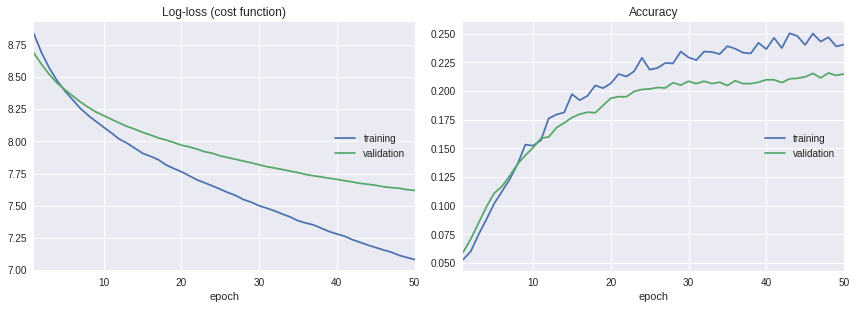

In [0]:
batch_size = 35
epochs = 50

trainingCNN = model.fit(X_train, y_train_genres,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    shuffle = False, 
                    validation_data = [X_test,y_test_genres],callbacks=[PlotLossesKeras()])

In [0]:
model1=model.predict(X_test)

In [0]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [0]:
auc = roc_auc_score(y_test_genres, model1, average="macro")

In [0]:
print(auc)

0.5793164558024364


## Activations, Dropout & Optimizers

### Different tests are carried out where activators and optimizers are changed, in order to find the best set of options that allow improving the model.

In [0]:
outputClasses = 24

model1B = Sequential()
model1B.add(Conv1D(32,32, input_shape=(256,160)))
model1B.add(BatchNormalization(axis=-1))
model1B.add(Activation('elu'))
model1B.add(Conv1D(32, 32))
model1B.add(BatchNormalization(axis=-1))
model1B.add(Activation('elu'))

model1B.add(Conv1D(64,32))
model1B.add(BatchNormalization(axis=-1))
model1B.add(Activation('relu'))
model1B.add(Conv1D(64,32))
model1B.add(Dropout(0.5))
model1B.add(BatchNormalization(axis=-1))
model1B.add(Activation('relu'))

model1B.add(Flatten())

# Fully connected layer
model1B.add(Dense(512))
model1B.add(BatchNormalization())
model1B.add(Activation('selu'))
model1B.add(Dropout(0.5))
model1B.add(Dense(outputClasses))

model1B.add(Activation('sigmoid'))
model1B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 225, 32)           163872    
_________________________________________________________________
batch_normalization_33 (Batc (None, 225, 32)           128       
_________________________________________________________________
activation_42 (Activation)   (None, 225, 32)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 194, 32)           32800     
_________________________________________________________________
batch_normalization_34 (Batc (None, 194, 32)           128       
_________________________________________________________________
activation_43 (Activation)   (None, 194, 32)           0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 163, 64)           65600     
__________

In [0]:
from keras.optimizers import adam
from keras.optimizers import SGD
from keras.optimizers import adamax
from keras.optimizers import RMSprop
from livelossplot import PlotLossesKeras

#Defines optimizer.
op = RMSprop(lr=0.0001)

# Compile the neural network.
model1B.compile(loss='categorical_crossentropy',
             optimizer=op,
              metrics=['accuracy'])

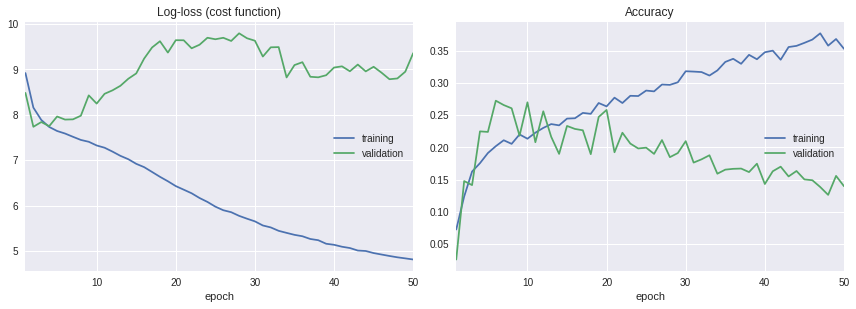

In [0]:
batch_size = 35
epochs = 50

trainingCNN = model1B.fit(X_train, y_train_genres,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    shuffle = False, 
                    validation_data = [X_test,y_test_genres],callbacks=[PlotLossesKeras()])

In [0]:
model1B=model.predict(X_test)

In [0]:
auc = roc_auc_score(y_test_genres, model1B, average="macro")
print(auc)

0.5793164558024364


### Transfer learning With VGG16

![Image of Yaktocat](https://www.researchgate.net/publication/321829624/figure/fig2/AS:571845657481217@1513350037610/VGG16-architecture-16.ppm)

###  Since VGG16 worked on color images, a transformation was made in order to work with images in grids, for this network two dense layers with sigmoid activations, a Rmsprop optimizer and a learning rate of 0.0001 were used. With this network a total of 6,566,424 parameters were obtained

In [0]:
from keras.applications import VGG16
from skimage.transform import resize

vgg16 = VGG16(include_top=False, weights='imagenet')

def apply_vgg_grayscale(images):

    images_ = []
    for img in tqdm(images):

        # reshape
        img = img.reshape((256, 160))

        # rescale
        img = resize(img, (160, 160), mode='reflect')

        # repeat
        img = [img] * 3

        images_.append(img)


    # To numpy array
    images_ = np.array(images_)

    # move channel to last axis
    images_ = np.rollaxis(images_, 1, 4)

    # Apply vgg
    images_vgg = vgg16.predict(images_)
    
    return images_vgg

images_training_vgg = apply_vgg_grayscale(images_training)
images_training_vgg.shape

images_testing_vgg = apply_vgg_grayscale(images_testing)
images_testing_vgg.shape

58892288/58889256 [==============================] - 2s 0us/step


100%|██████████| 3383/3383 [00:08<00:00, 383.25it/s]


(3383, 5, 5, 512)

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training_vgg, y_genres, test_size=0.3, random_state=110)

In [0]:
X_test.shape

(2369, 5, 5, 512)

In [0]:
from keras.optimizers import RMSprop
vgg16 = Sequential()
vgg16.add(Flatten(input_shape=(5,5,512)))
vgg16.add(Dense(512, activation='sigmoid'))
vgg16.add(Dropout(0.5))
vgg16.add(Dense(24, activation='sigmoid'))
vgg16.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               6554112   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                12312     
Total params: 6,566,424
Trainable params: 6,566,424
Non-trainable params: 0
_________________________________________________________________


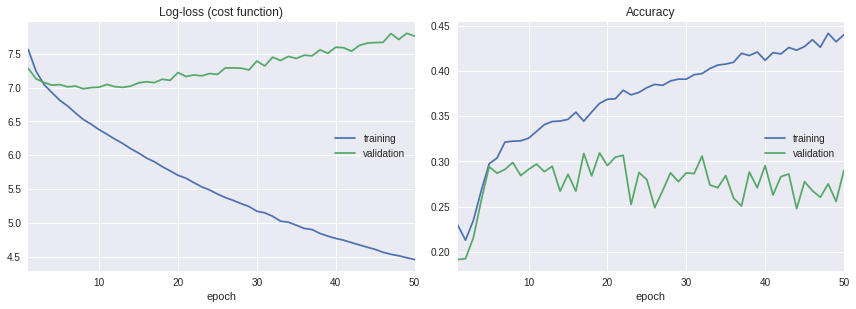

In [0]:
vgg16.fit(X_train, y_train_genres, validation_data=[X_test, y_test_genres], epochs=50, verbose=2, callbacks=[PlotLossesKeras()])

In [0]:
model2=vgg16.predict(X_test)

In [0]:
auc = roc_auc_score(y_test_genres, model2, average="macro")

In [0]:
print(auc)

0.6924514648666734


In [0]:
from google.colab import files


cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = vgg16.predict(images_testing_vgg)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img.csv', index_label='ID')

files.download('pred_genres_img.csv')

## VVG19

### Transfer learning With VGG19

![Image of Yaktocat](https://cdn-images-1.medium.com/max/1600/1*cufAO77aeSWdShs3ba5ndg.jpeg)

### Since VGG19 worked on color images, a transformation was made in order to work with images in grits, for this network we used two dense layers with sigmoid activations, an Rmsprop optimizer and a learning rate of 0.0001. With this network a total of 6,566,424 parameters were obtained




In [0]:
from keras.applications import VGG19
from skimage.transform import resize

vgg19 = VGG19(include_top=False, weights='imagenet')

def apply_vgg_grayscale(images):

    images_ = []
    for img in tqdm(images):

        # reshape
        img = img.reshape((256, 160))

        # rescale
        img = resize(img, (160, 160), mode='reflect')

        # repeat
        img = [img] * 3

        images_.append(img)


    # To numpy array
    images_ = np.array(images_)

    # move channel to last axis
    images_ = np.rollaxis(images_, 1, 4)

    # Apply vgg
    images_vgg19 = vgg19.predict(images_)
    
    return images_vgg19

images_training_vgg19 = apply_vgg_grayscale(images_training)
images_training_vgg19.shape

images_testing_vgg19 = apply_vgg_grayscale(images_testing)
images_testing_vgg19.shape

80142336/80134624 [==============================] - 1s 0us/step


100%|██████████| 3383/3383 [00:09<00:00, 351.75it/s]


(3383, 5, 5, 512)

In [0]:
X_train19, X_test19, y_train_genres19, y_test_genres19 = train_test_split(images_training_vgg19, y_genres, test_size=0.3, random_state=110)

In [0]:
X_test19.shape

(2369, 5, 5, 512)

In [0]:
from keras.optimizers import RMSprop
vgg19 = Sequential()
vgg19.add(Flatten(input_shape=(5,5,512)))
vgg19.add(Dense(512, activation='sigmoid'))
vgg19.add(Dropout(0.5))
vgg19.add(Dense(24, activation='sigmoid'))
vgg19.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               6554112   
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 24)                12312     
Total params: 6,566,424
Trainable params: 6,566,424
Non-trainable params: 0
_________________________________________________________________


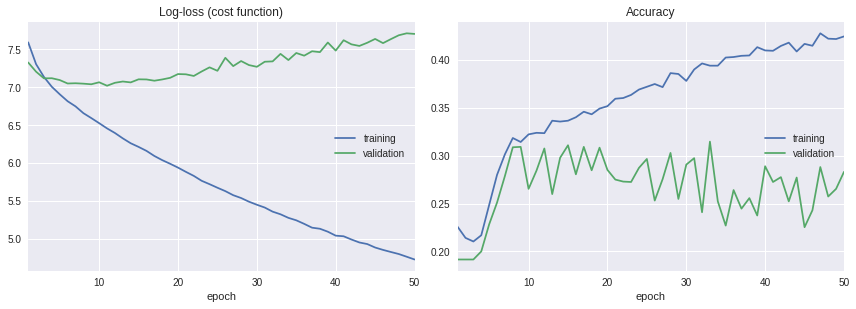

In [0]:
vgg19.fit(X_train19, y_train_genres19, validation_data=[X_test19, y_test_genres19], epochs=50, verbose=2, callbacks=[PlotLossesKeras()])

In [0]:
model19=vgg19.predict(X_test19)

In [0]:
auc = roc_auc_score(y_test_genres, model19, average="macro")

In [0]:
print(auc)

0.6765073548680146


#  Text Classification

###  For this part two processes are carried out in order to train the model one is by means of the transformation of the information of the synopsis creating a vector with the counting of the words, limiting the quantity of characteristics, modifying the n-grams, changing the lowercase words and quintando the Stop Words placing, for the second method a vocabulary and a maximum number of words that are going to enter inside the network are created and this is the information that enters inside the embedding of the LSTM.

In [0]:
Xtraintext = dataTraining['plot']
Xtrainname = dataTraining['title']

Xtesttext = dataTesting['plot']
Xtestname = dataTesting['title']
Xtraintext.shape
dataTraining['genres'].shape

(7895,)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect = CountVectorizer(max_features=1000,ngram_range =(1,3),lowercase=True,stop_words='english')
X_dtm_text = vect.fit_transform(Xtraintext)
X_dtm_name = vect.fit_transform(Xtrainname)
Y_dtm_text = vect.fit_transform(Xtesttext)
Y_dtm_name = vect.fit_transform(Xtestname)

le = MultiLabelBinarizer()
y_genres_2 = le.fit_transform(dataTraining['genres'])

In [0]:
X_dtm_name.shape

(7895, 1000)

In [0]:
y_genres_2.shape

(7895, 24)

In [0]:
X_train_text, X_test_text, y_train_genres_text, y_test_genres_text = train_test_split(X_dtm_text, y_genres_2, test_size=0.3, random_state=110)
X_train_name, X_test_name, y_train_genres_name, y_test_genres_name = train_test_split(X_dtm_name, y_genres_2, test_size=0.3, random_state=110)

 # CNN  for Text
 

 
 
![Image of Yaktocat]( https://richliao.github.io/images/YoonKim_ConvtextClassifier.png)


### This network has the following characteristics three dense layers with hypogenetic tangent activations, softmax, with two DropOuts of 0.5 and Rmsprop optimizer with learning rate of 0.0001



In [0]:
from keras.layers.recurrent import LSTM
model_text = Sequential()

model_text.add(Dense(128, input_shape=(1000,)))
model_text.add(Activation('tanh'))
model_text.add(BatchNormalization())
model_text.add(Dropout(0.5))

model_text.add(Dense(128))
model_text.add(Activation('softmax'))
model_text.add(BatchNormalization())
model_text.add(Dropout(0.5))

model_text.add(Dense(24))
model_text.add(Activation('sigmoid'))


model_text.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])
model_text.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               128128    
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
__________

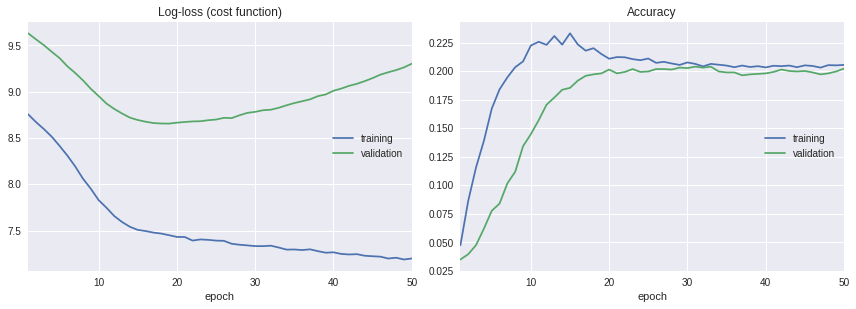

In [0]:
model_text.fit(X_train_name, y_train_genres_name, validation_data=[X_test_text, y_test_genres_text], epochs=50, verbose=2, callbacks=[PlotLossesKeras()])

In [0]:
model3=model_text.predict(X_test_name)

In [0]:
auc = roc_auc_score(y_test_genres_name, model3, average="macro")

In [0]:
print(auc)

0.5923461361103824


In [0]:
from google.colab import files


cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model_text.predict(Y_dtm_name)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img.csv', index_label='ID')

files.download('pred_genres_img.csv')

# LSTM

 
![Image of Yaktocat]( https://skymind.ai/images/wiki/greff_lstm_diagram.png)


### This network has the following characteristics, a dense layer with sigmoid activations, with two DropOuts of 0.5 and Rmsprop optimizer with learning rate of 0.00001


In [0]:
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


In [0]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
import keras
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


In [0]:
X = dataTraining['plot'].tolist()

In [0]:
voc = set(''.join(X))
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

In [0]:
# Max len
max_plot_len = 150
X = [x[:max_plot_len] for x in X]
# Convert characters to int and pad
X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X]

In [0]:
len(X)

7895

In [0]:
X_pad = sequence.pad_sequences(X, maxlen=max_plot_len)

In [0]:
  X_pad

array([[42, 17, 47, ...,  8,  8, 62],
       [ 0,  0,  0, ..., 49,  8, 35],
       [31,  3,  8, ..., 31, 16,  8],
       ...,
       [16, 31, 49, ..., 31,  3, 14],
       [42, 61, 47, ..., 70, 15,  6],
       [ 0,  0,  0, ...,  6,  8, 35]], dtype=int32)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_genres_2, test_size=0.33, random_state=110)

In [0]:
model_text_2 = Sequential()
model_text_2.add(Embedding(len(vocabulary) + 1, 128, input_length=max_plot_len))
model_text_2.add(LSTM(64))
model_text_2.add(Dropout(0.5))
model_text_2.add(Dense(24, activation='sigmoid'))
model_text_2.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.00001), metrics=['accuracy'])

model_text_2.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 128)          9600      
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 24)                1560      
Total params: 60,568
Trainable params: 60,568
Non-trainable params: 0
_________________________________________________________________


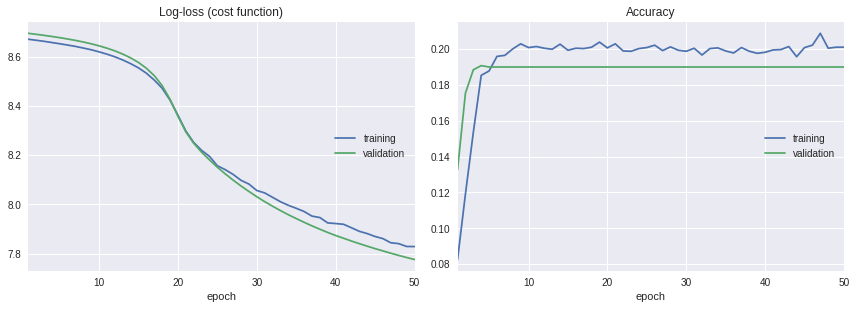

In [0]:
model_text_2.fit(X_train, y_train, validation_data=[X_test, y_test], 
          batch_size=100, epochs=50, verbose=1,
          callbacks=[PlotLossesKeras()])

In [0]:
model4=model_text_2.predict(X_test)

In [0]:
auc = roc_auc_score(y_test, model4, average="macro")
print(auc)

0.5088667856082103


## Model 5 Text

### A change to the model is made, including Conv1D with activation Relu, Dropout 0.5, MaxPooling1D pool_size 2 and optimizer adam

In [0]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model_text_3 = Sequential()
model_text_3.add(Embedding(len(vocabulary) + 1, 128, input_length=max_plot_len))
model_text_3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_text_3.add(Dropout(0.5))
model_text_3.add(MaxPooling1D(pool_size=2))
model_text_3.add(LSTM(128))
model_text_3.add(Dense(24, activation='sigmoid'))
model_text_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_text_3.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 150, 128)          9600      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 150, 32)           12320     
_________________________________________________________________
dropout_18 (Dropout)         (None, 150, 32)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 75, 32)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dense_21 (Dense)             (None, 24)                3096      
Total params: 107,448
Trainable params: 107,448
Non-trainable params: 0
_________________________________________________________________
None

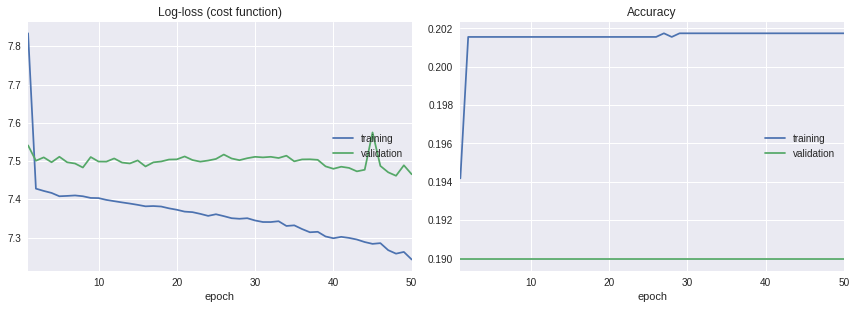

In [0]:
model_text_3.fit(X_train, y_train, validation_data=[X_test, y_test], 
          batch_size=128, epochs=50, verbose=1,
          callbacks=[PlotLossesKeras()])

In [0]:
model5=model_text_3.predict(X_test)

In [0]:
auc = roc_auc_score(y_test, model5, average="macro")
print(auc)

0.5061839471966222


## Model 6 Text

#### A change is made to the model, including Conv1D with activation Relu, Dropout 0.5, MaxPooling1D pool_size 2, a dense layer and tested with different activations along with different optimizers being adam with the best performance

In [0]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model_text_4 = Sequential()
model_text_4.add(Embedding(len(vocabulary) + 1, 128, input_length=max_plot_len))
model_text_4.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_text_4.add(Dropout(0.5))
model_text_4.add(MaxPooling1D(pool_size=2))
model_text_4.add(LSTM(128))
model_text_4.add(Dense(128))
model_text_4.add(Activation('relu'))
model_text_4.add(Dropout(0.5))
model_text_4.add(Dense(24, activation='sigmoid'))
model_text_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_text_4.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 150, 128)          9600      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 150, 32)           12320     
_________________________________________________________________
dropout_15 (Dropout)         (None, 150, 32)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 75, 32)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_11 (Activation)   (None, 128)               0         
__________

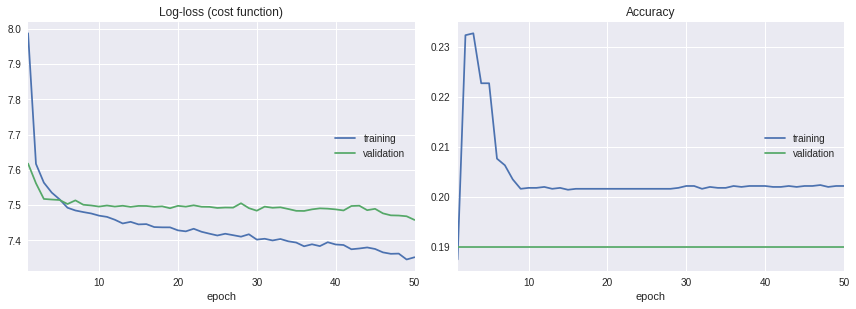

In [0]:
model_text_4.fit(X_train, y_train, validation_data=[X_test, y_test], 
          batch_size=128, epochs=50, verbose=1,
          callbacks=[PlotLossesKeras()])

In [0]:
model6=model_text_4.predict(X_test)

In [0]:
auc = roc_auc_score(y_test, model6, average="macro")
print(auc)

0.5449665531039436


# Unique Solution by Best Models Combine


 
![Image of Yaktocat]( https://cdn-images-1.medium.com/max/1000/1*fy-6esoTWsTutld4fdSyCQ.png)


### The method is to average the results of the best models in text and images



In [0]:
y_pred_test_genres.shape


(3383, 24)

In [0]:
y_pred_test_genres[1,1]

0.0026529268

In [0]:
Y = dataTesting['plot'].tolist()

voc1 = set(''.join(Y))
vocabulary1 = {x: idx + 1 for idx, x in enumerate(set(voc1))}

# Max len
max_plot_len = 150
Y = [x[:max_plot_len] for x in Y]
# Convert characters to int and pad
Y = [[vocabulary1[x1] for x1 in x if x1 in vocabulary1.keys()] for x in Y]

len(Y)

Y_pad = sequence.pad_sequences(Y, maxlen=max_plot_len)


In [0]:
Y_pad.shape

(3383, 150)

In [0]:
numpy.random.seed(110)
y_pred_test_genres_text=model_text_2.predict(Y_pad)

In [0]:
y_pred_test_genres_text[1,1]

0.65275365

In [0]:
y_pred_test_genres_text.shape

(3383, 24)

In [0]:
X =y_pred_test_genres_text
Y = y_pred_test_genres
len(X[0])

24

In [0]:
result = np.zeros((3383,24))
result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
result = [[(X[i][j] + Y[i][j])/2  for j in range(len(X[0]))] for i in range(len(X))]
   

In [0]:
from google.colab import files


cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

pd.DataFrame(result, index=dataTesting.index, columns=cols).to_csv('pred_combine_img.csv', index_label='ID')

files.download('pred_combine_img.csv')

## Conclusions

###  In order to find the method that would best classify the categories of the films, different kinds of text and image classification methods were carried out, the text classification being the one with the best accuracy in all the methods. It is important to mention that the methods of Machine Learning had better performance than those of Deep learning, even with the assembly of results of the best two models.